# MAC0318 - Estimação de estado - Notebook 1

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e as bibliotecas NumPy e Matplotlib instaladas. 
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter, a manipulação de matrizes usando a bilbioteca NumPy e conhecimento de teoria de probabilidades. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso.

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckietown` do conda antes de abrir o jupyter notebook e escolher o kernel `duckietown`, para que os requerimentos sejam satisfeitos.</red>

## Estimação de estado

Vamos construir um estimador de crença usando um filtro bayesiano para um domínio simples no qual um robô se locomove entre 4 células conectadas como na figura abaixo, e sensoria apenas a cor de cada célula:


<figure style="text-align: center">
    <img src="img/mundo1d-num.png" width=400>
</figure>

Para esse domínio simples, a variável de estado será representada por um processo estocástico discreto $X_t$ que toma valores em $\{1,2,3,4\}$ e a variável de observação será representada por um processo estocástico discreto $Y_t$ que toma valores binários representando as cores vermelha ($Y=0$) e verde ($Y=1$). O agente possui ações de mover-se à célula à esquerda ($u=-1$) ou à direita ($u=1$), que nem sempre são bem sucedidas. Por último, vamos tambem assumir que o tempo é discreto, ou seja, que o agente atualiza sua crença em instantes de tempo $t_0, t_0 + 1, \ldots$, também conhecidos como estágios de decisão.

In [1]:
# Vamos carregar os pacotes necessários

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Vamos representar os suportes de cada variável aleatória por variáveis de programação de mesmo nome.

In [2]:
X = [1, 2, 3, 4]     # estados (células)
Y = [0, 1]           # observações: 0 - vermelho, 1 - verde
mapa = [0, 1, 1, 0]  # contém cor de cada célula

Vamos especificar um sensor perfeito, ou seja, que identifica a cor exata da célula na qual o robô se encontra.

In [3]:
def sensor(y, x): 
    ''' Returns P(Y=y | X=x). '''
    if mapa[x-1] == y:
        return 1.0
    else:
        return 0.0

In [4]:
for x in X:
    for y in Y:
        print(f'P(Y={y}|X={x}) =', sensor(y,x))

P(Y=0|X=1) = 1.0
P(Y=1|X=1) = 0.0
P(Y=0|X=2) = 0.0
P(Y=1|X=2) = 1.0
P(Y=0|X=3) = 0.0
P(Y=1|X=3) = 1.0
P(Y=0|X=4) = 1.0
P(Y=1|X=4) = 0.0


Vamos especificar a função de transição (modelo do processo, de dinâmica ou de ação):
$$
P(X_{t+1}=x' | X_t=x, u) = \begin{cases} 1/4 & \text{ se } x'=x \text{ ou } x'=x+2u\\1/2 & \text{se } x'=x+u \end{cases}
$$

De acordo com a função acima, o robô se movimenta para a célula pretendida com probabilidade 1/2 e com probabilidade 1/2 a ação falha e ele permance na mesma célula ou atinge a célula seguinte à pretendida. Nas células sem vizinhança na direção pretendida (por exemplo, $X=1$ para ação $u=1$) a ação faz o agente permanecer na mesma célula, por exemplo, $P(X_{t+1}=1|X_t=1, u=-1)=1$.

Vamos representar as distribuições condicionais $P(X_{t+1}=x'|X_t=x, u)$ para uma dada ação $u$ como uma matriz $T[x',x]$ cuja coluna indica o valor do estado atual $x$ e cuja linha indica o valor do estado futuro $x'$. Dessa forma, os valores em cada coluna devem somar 1.

In [5]:
# T(x,u,x') = P(X'=x'|X=x,u)

T = {
    1: # u = direita 
     np.matrix( [[1/4, 0.0, 0.0, 0.0],  
                 [1/2, 1/4, 0.0, 0.0],
                 [1/4, 1/2, 1/4, 0.0],
                 [0.0, 1/4, 3/4, 1.0]]),

   -1: # u = esquerda
     np.matrix( [[1.0, 3/4, 1/4, 0.0], 
                 [0.0, 1/4, 1/2, 1/4],
                 [0.0, 0.0, 1/4, 1/2], 
                 [0.0, 0.0, 0.0, 1/4]])
    }

## Filtro Bayesiano

O Filtro bayesiano calcula a crença 
$$
 \text{bel}(x_t) = P(X_t = x_t | y_0,\ldots,y_t,u_0,\ldots,u_t)
$$
sobre o estado atual $X_t$ a partir de todas as ações $u$ e observações $y$ anteriores. 

Para facilitar as computações, vamos representar a crença por um vetor (ou tensor unidimensional)

```python
  bel = np.array([p1, p2, p3, p4]).T
```

onde `p1`, ..., `p4` são as probabilidades de cada célula (estado).

In [6]:
# Crença uniforme sobre todos os estado -- máxima ignorância/incerteza

bel = np.array([1/4, 1/4, 1/4, 1/4]).T

A função a seguir exibe a crença em um dado instante

In [7]:
def show_belief(p):
    ''' Shows bar plot of belief funciton. '''
    p = p.flatten()
    states = plt.bar(X, p)
    colors = {0: 'red', 1: 'green'}
    for i in range(len(states)):
        states[i].set_facecolor(colors[mapa[i]])
    plt.xticks(X)
    plt.ylim([0, 1])
    plt.ylabel('bel(X)')
    plt.xlabel('X') 

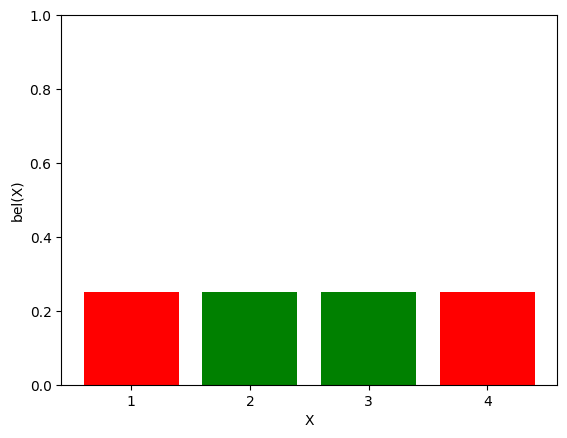

In [8]:
# Mostrando a crença atual

show_belief(bel)

O Filtro Bayesiano assume que **estado e observação são markovianos** para  obter uma fórmula recursiva para o cálculo da crença atual a partir da crença prévia em duas etapas: 

- Correção, na qual informação de observação é incorporada à crença, e 
- Predição, na qual informação sobre a ação executada pelo agente é considerada.

### Correção

Considere que nosa crença no instante $t$ é a distribuição de probabilidades $\text{bel}_t(x)=P(X_t = x)$ e que recebemos uma observação $Y_t=y$. Note que omitimos a dependência em informações anteriores, pois elas não são relevantes devido à hipótese de markovianidade do filtro. A etapa de correção atualiza a crença por:

$$
    \text{bel}_{t+1}(x) = P(X_{t+1}=x|y) = \frac{p(y | x)\text{bel}_t(x)}{p(y)}
$$

O denominador da equação acima é constante em relação ao estado $x$. Dessa forma, e lembrando a propriedade de distribuição de probabilidades, $\sum_{x=1}^4 P(X_{t+1}=x) = 1$, podemos calculá-la como a constante de normalização da versão não normalizada:

$$
    \tilde{\text{bel}}_{t+1}(x) = p(y | x)\text{bel}_t(x) .
$$

Em termos vetoriais, a equação acima computa o produto ponto-a-ponto de dois vetores cujas posições correspondem aos estados $x$.

In [9]:
def correct(b, y):
    ''' Update belief vector b given observation y -- Calls sensor model sensor(y) = P(Y=y|X).  '''
    tilde_bel = np.array([sensor(y,x) for x in X]).T # P(Y=y|X=x)
    tilde_bel *= b # bel(X) * P(y|X)
    # normaliza e atualiza vetor de crença
    b[:] = tilde_bel/np.sum(tilde_bel) 


Vamos testar a equação de correção quando observamos a cor verde

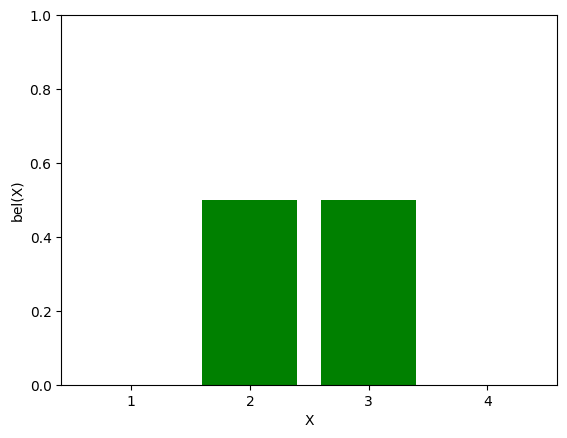

In [10]:
# observar (verde)
correct(bel, 1)

show_belief(bel) 

### Predição

A segunda etapa do filtro bayesiano atualiza a crença para uma dada ação $u$ por meio da fórmula:
$$
  \text{bel}_{t+1}(x') = \sum_{x} P(X_{t+1}=x' | X_t=x, u) \text{bel}_t(x) .
$$

Em notação matricial, com $\text{bel}$ representado como um vetor `bel` e a função de transição como uma matriz `T[u]` na forma descrita anterioremente, a equação acima pode ser escrita como
$$
  bel = T[u] * bel
$$

In [11]:
def predict(b, u):
    ''' Update belief given action u - uses transition matrix T[u][x',x] = P(X'=x'|X=x,u). '''
    b[:] = T[u] @ b

Vamos testar para uma ação de mover-se para a célula à direita a partir da crença atual

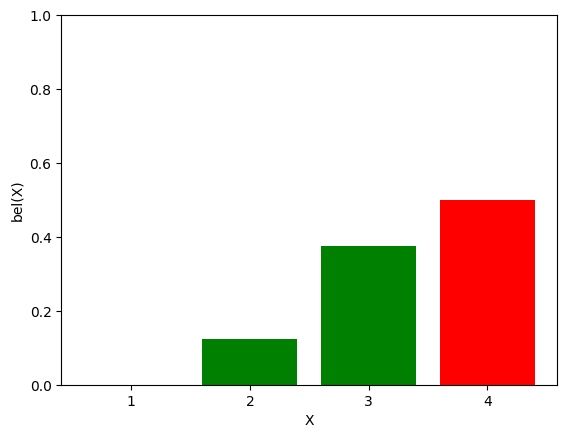

In [12]:
# mover para direita
predict(bel, 1)

show_belief(bel)

## Estimação pontual de estado

Para transformamos a crença em uma sinal de erro utilizável por controlador (PID) precisamos extrair um sumário ou estatística da função. Para o caso de variáveis categóricas (cujos valores não possuem significado numérico, como as observações) ou para o caso de variáveis multimodais (ou seja, cujas distribuição de probabilidades possuem vários pontos de máximo locais), o mais comum é usar a **moda** da distribuição ou o valor mais provável, também conhecido como inferência de máximo a posteriori ou MAP (do inglês, _maximum a posteriori_).

No nosso domínio simples, os estados podem ser entendidos como discretização de valores contínuous de posição, de forma que também é possível obter uma estatística que combine informação de toda a função de crença como a **média** ou valor esperado. 

Essas estatísticas são implementadas abaixo

In [13]:
def get_mode(b):
    ''' Extract most probable belief state. '''
    mode = X[0]
    map_value = 0.0 # maximum state probability
    for i,x in enumerate(X): # implementação ineficiente para fins didáticos!
        if b[i] > map_value:
            map_value = b[i]
            mode = x
    return mode

In [14]:
def get_mean(b):
    ''' Extract mean belief state value. '''
    mean = 0.0
    for i,x in enumerate(X): # impementação ineficiente para fins didáticos!
        mean += x*b[i]
    return mean

Para nossa crença atual, essas estatísticas resultam nos seguintes descritores:

In [15]:
x = get_mode(bel)
print('Mode state:', x)
x = get_mean(bel)
print('Mean state:', x)

Mode state: 4
Mean state: 3.375


## 💡 Exercício 1

Use as funções espeficicadas para simular um agente que se locomove com movimentos aleatórios (ou seja, a cada passo desloca-se para direita ou esquerda com igual probabilidade). Observe como a crença do agente se modifica. Em particular, note que a etapa de correção diminui a incerteza, enquanto a etapa de predição aumenta a incerteza. Também repare como movimentos para as bordas diminuem a incerteza em função das ações se tornarem determinísticas. Rode simulações com crenças iniciais distintas também, por exemplo, além da completa ignorância do estado inicial, representada pela distribuição uniforme a priori, uma crença que atribui probabilidade 1/2 ao estado inicial estado e 1/4 ao estados vizinhos.

In [16]:
# Implementar simulação descrita acima

# Gera posição inicial aleatória entre X[0] e X[-1] (inclusive)
x_true = np.random.randint(X[0],X[-1]+1) 

# Para gerar uma ação aleatória -1 ou 1 com mesma probabilidade:
u = 2*np.random.randint(0,2) - 1 

## 💡 Exercício 2

Refaça suas investigações considerando um domínio mais complexo, composto de 100 células e um sensor imperfeito, que devolve a cor errada com probabilidade 0,1. Como o comportamento do filtro bayesian se diferencia nesse caso?

In [16]:
def sensor(y, x): 
    ''' Returns P(Y=y | X=x). '''
    # Modifique essa função para que ela simule um sensor que erra com probabilidade 0,1
    if mapa[x-1] == y:
        return 1.0
    else:
        return 0.0

In [17]:
# simular filtro em domínio maior
X = np.arange(1,101)     # estados (células)
Y = [0, 1]               # observações: 0 - vermelho, 1 - verde
mapa = np.random.randint(0,2,len(X))      # mapa aleatório -- contém cor de cada célula